In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.linalg import sqrtm, eig, norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from estimate import test_mse_pop

plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams.update({"font.size": 15})

In [2]:
# DAG
p = 21
B = np.loadtxt("B_20.csv")
b_causal = B[-1, :-1]
C = np.linalg.inv(np.identity(p) - B)

# Observational stats
S_eps = np.random.rand(p, p)
S_eps = S_eps @ S_eps.T
S_eps = np.eye(p) + S_eps
Gram_0 = C @ S_eps @ C.T
Sigma_0 = Gram_0

# Interventional stats
mu1_noise = np.random.rand(p)
mu1_noise = mu1_noise / norm(mu1_noise, 2)
mu1_noise[-1] = 0
S1 = np.random.rand(p, p)
S1 = S1 @ S1.T
S1[-1, :] = 0
S1[:, -1] = 0
S1 = S1 / norm(S1, 2)
mu1 = C @ mu1_noise
Sigma_1 = C @ (S_eps + S1) @ C.T
Gram_1 = Sigma_1 + np.outer(mu1, mu1)
delta_x = (Gram_1[:-1,:-1] - Gram_0[:-1,:-1])/2
delta_xy = (Gram_1[:-1, -1] - Gram_0[:-1, -1])/2

# Test distribution
S_t = np.random.rand(p, p)
S_t = S_t @ S_t.T
S_t[-1, :] = 0
S_t[:, -1] = 0
S_t = S_t / norm(S_t, 2)
mu_t = np.random.rand(p)
mu_t = mu_t / norm(mu_t, 2)
mu_t[-1] = 0

In [3]:
# Estimations
gamma = 10
M = (Gram_1[:-1, :-1] - Gram_0[:-1, :-1]) * gamma / 2 + Gram_0[:-1, :-1]
N = gamma / 2 * (Gram_1[:-1, -1] - Gram_0[:-1, -1]) + Gram_0[:-1, -1]
b_drig = inv(M) @ N
b_anchor = inv(Gram_0[:-1, :-1] + Gram_1[:-1, :-1] + (gamma - 1) * np.outer(mu1[:-1], mu1[:-1])) @ (Gram_0[:-1, -1] + Gram_1[:-1, -1] + (gamma - 1) * mu1[:-1] * mu1[-1])
b_pooled = inv(Sigma_0[:-1, :-1] + Sigma_1[:-1, :-1] + np.outer(mu1[:-1], mu1[:-1])) @ (Sigma_0[:-1, -1] + Sigma_1[:-1, -1] + mu1[:-1] * mu1[-1])
b_obs = inv(Sigma_0[:-1, :-1]) @ Sigma_0[:-1, -1]

In [4]:
# Test 

# Loop through perturbation strengths
perturb_stren = np.linspace(0.1, 100, 100)

mse_drig = []
mse_anchor = []
mse_pooled = []
mse_obs = []
mse_causal = []
mse_adap = []
mse_adap_est = None
mse_test_ols = None
mse_test_oracle = []
n_test = 50
num_repeat = 50
for l in perturb_stren:
    Gram_t = C @ (S_eps + l * (S_t + np.outer(mu_t, mu_t))) @ C.T
    b_test_oracle = inv(Gram_t[:-1,:-1]) @ Gram_t[:-1,-1]
    Sigma_t = S_eps + l*S_t
    Sigma_t_eigen = eig(Sigma_t)
    
    gram_x_est = Gram_t[:-1,:-1]
    scaling_xx = sqrtm(inv(gram_x_est))
    
    sqrt_delta_x = sqrtm(delta_x)
    sqrt_delta_x_inv = inv(sqrt_delta_x)
    big_gamma_x = sqrt_delta_x_inv @ sqrtm(sqrt_delta_x @ (Gram_t[:-1,:-1] - Gram_0[:-1,:-1]) @ sqrt_delta_x) @ sqrt_delta_x_inv
    gamma_y_base = scaling_xx @ big_gamma_x @ delta_xy
    big_gamma_y = gamma_y_base.T @ scaling_xx @ (Gram_t[:-1,-1] - Gram_0[:-1,-1]) / (norm(gamma_y_base, 2))**2
    M = big_gamma_x @ (Gram_1[:-1, :-1] - Gram_0[:-1, :-1]) @ big_gamma_x / 2 + Gram_0[:-1, :-1]
    N = big_gamma_y / 2 * big_gamma_x @ (Gram_1[:-1, -1] - Gram_0[:-1, -1]) + Gram_0[:-1, -1]
    b_adap = inv(M) @ N
    
    mse_adap_est1 = []
    mse_test_ols1 = []
    for i in range(num_repeat):
        test_noise = (np.random.uniform(size=n_test*p)-0.5)*np.sqrt(12)
        test_noise = np.reshape(test_noise, (n_test, p)).dot(np.transpose(Sigma_t_eigen[1].dot(np.diag(np.sqrt(Sigma_t_eigen[0]))))) + np.sqrt(l)*mu_t
        test_data = test_noise.dot(C.T)

        Exy_est = np.mean(test_data[:,:-1] * np.expand_dims(test_data[:,-1], 1), axis=0)
        big_gamma_x = sqrt_delta_x_inv @ sqrtm(sqrt_delta_x @ (gram_x_est - Gram_0[:-1,:-1]) @ sqrt_delta_x) @ sqrt_delta_x_inv
        big_gamma_y = gamma_y_base.T @ scaling_xx @ (Exy_est - Gram_0[:-1,-1]) / (norm(gamma_y_base, 2))**2
        M = big_gamma_x @ (Gram_1[:-1, :-1] - Gram_0[:-1, :-1]) @ big_gamma_x / 2 + Gram_0[:-1, :-1]
        N = big_gamma_y / 2 * big_gamma_x @ (Gram_1[:-1, -1] - Gram_0[:-1, -1]) + Gram_0[:-1, -1]
        b_adap_est = inv(M) @ N
        b_test_ols = inv(gram_x_est) @ Exy_est
        mse_adap_est1.append(np.real(test_mse_pop(Gram_t, b_adap_est)))
        mse_test_ols1.append(np.real(test_mse_pop(Gram_t, b_test_ols)))
    mse_adap_est1 = pd.DataFrame({
        "perturb_stren": np.repeat(l, num_repeat),
        "MSE": np.array(mse_adap_est1)
    })
    mse_test_ols1 = pd.DataFrame({
        "perturb_stren": np.repeat(l, num_repeat),
        "MSE": np.array(mse_test_ols1)
    })
    mse_adap_est = mse_adap_est1 if mse_adap_est is None else pd.concat([mse_adap_est, mse_adap_est1], ignore_index=True)
    mse_test_ols = mse_test_ols1 if mse_test_ols is None else pd.concat([mse_test_ols, mse_test_ols1], ignore_index=True)
    
    mse_drig.append(test_mse_pop(Gram_t, b_drig))
    mse_anchor.append(test_mse_pop(Gram_t, b_anchor))
    mse_pooled.append(test_mse_pop(Gram_t, b_pooled))
    mse_causal.append(test_mse_pop(Gram_t, b_causal))
    mse_adap.append(test_mse_pop(Gram_t, b_adap))
    mse_test_oracle.append(test_mse_pop(Gram_t, b_test_oracle))

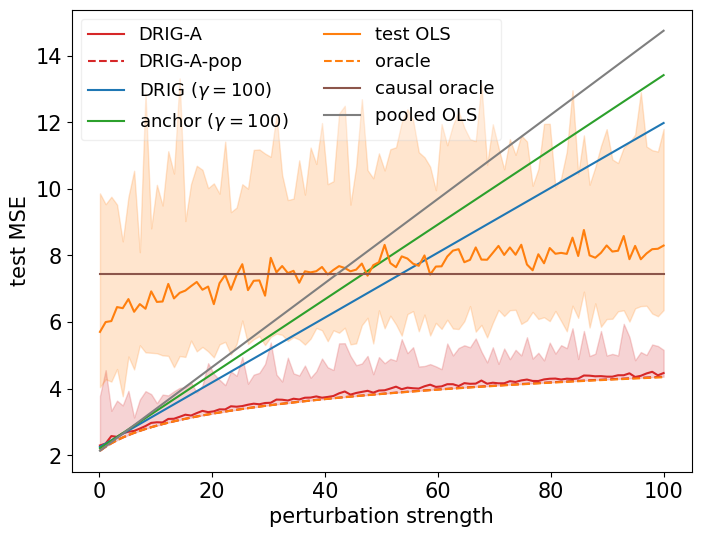

In [5]:
# Plotting
plt.figure()
sns.lineplot(data=mse_adap_est, x="perturb_stren", y="MSE", estimator="median", errorbar=("pi", 95), label="DRIG-A", color="C3")
plt.plot(perturb_stren, mse_adap, label="DRIG-A-pop", linestyle="dashed", color="C3")
plt.plot(perturb_stren, mse_drig, label="DRIG ($\gamma=100$)", color="C0")
plt.plot(perturb_stren, mse_anchor, label="anchor ($\gamma=100$)", color="C2")
sns.lineplot(data=mse_test_ols, x="perturb_stren", y="MSE", estimator="median", errorbar=("pi", 95), label="test OLS", color="C1")
plt.plot(perturb_stren, mse_test_oracle, label="oracle", linestyle="dashed", color="C1")
plt.plot(perturb_stren, mse_causal, label="causal oracle", color="C5")
plt.plot(perturb_stren, mse_pooled, label="pooled OLS", color="C7")

plt.xlabel("perturbation strength")
plt.ylabel("test MSE")
# plt.ylim(1.8,20)
plt.legend(loc="upper left", fontsize=13, ncol=2, framealpha=0.3)
# plt.savefig("./results/illus-adap.pdf", bbox_inches="tight")
plt.show()